# Using the SageMaker TensorFlow Serving Container

The [SageMaker TensorFlow Serving Container](https://github.com/aws/sagemaker-tensorflow-serving-container) makes it easy to deploy trained TensorFlow models to a SageMaker Endpoint without the need for any custom model loading or inference code.

In this example, we will show how deploy one or more pre-trained models from [TensorFlow Hub](https://www.tensorflow.org/hub/) to a SageMaker Endpoint using the [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk), and then use the model(s) to perform inference requests.

## Setup

First, we need to ensure we have an up-to-date version of the SageMaker Python SDK, and install a few
additional python packages.

In [1]:
!pip install -U --quiet "sagemaker>=1.14.2"
!pip install -U --quiet opencv-python tensorflow-hub

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Next, we'll get the IAM execution role from our notebook environment, so that SageMaker can access resources in your AWS account later in the example.

In [2]:
from sagemaker import get_execution_role

sagemaker_role = get_execution_role()

## Download and prepare a model from TensorFlow Hub

The TensorFlow Serving Container works with any model stored in TensorFlow's [SavedModel format](https://www.tensorflow.org/guide/saved_model). This could be the output of your own training job or a model trained elsewhere. For this example, we will use a pre-trained version of the MobileNet V2 image classification model from [TensorFlow Hub](https://tfhub.dev/).

The TensorFlow Hub models are pre-trained, but do not include a serving ``signature_def``, so we'll need to load the model into a TensorFlow session, define the input and output layers, and export it as a SavedModel. There is a helper function in this notebook's `sample_utils.py` module that will do that for us.

In [3]:
import sample_utils

model_name = 'mobilenet_v2_140_224'
export_path = 'mobilenet'
model_path = sample_utils.tfhub_to_savedmodel(model_name, export_path)

print('SavedModel exported to {}'.format(model_path))

W1023 17:01:15.719970 140045040965440 deprecation_wrapper.py:119] From /home/ec2-user/SageMaker/tensorflow-amazon-elastic-inference/lab1/sample_utils.py:31: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1023 17:01:18.220209 140045040965440 deprecation_wrapper.py:119] From /home/ec2-user/SageMaker/tensorflow-amazon-elastic-inference/lab1/sample_utils.py:38: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1023 17:01:18.967070 140045040965440 deprecation_wrapper.py:119] From /home/ec2-user/SageMaker/tensorflow-amazon-elastic-inference/lab1/sample_utils.py:51: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.

W1023 17:01:18.972594 140045040965440 deprecation_wrapper.py:119] From /home/ec2-user/SageMaker/tensorflow-amazon-elastic-inference/lab1/sample_utils.py:51: The name tf.tables_initializer is deprecated. Please use tf.compat.v1.tables_initializer in

SavedModel exported to mobilenet/mobilenet_v2_140_224/00000001


After exporting the model, we can inspect it using TensorFlow's ``saved_model_cli`` command. In the command output, you should see 

```
MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
...
```

The command output should also show details of the model inputs and outputs.

In [4]:
!saved_model_cli show --all --dir {model_path}


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['images'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: images:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['classes'] tensor_info:
        dtype: DT_INT32
        shape: (-1, 3)
        name: TopKV2:1
    outputs['probabilities'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3)
        name: TopKV2:0
  Method name is: tensorflow/serving/predict


## Optional: add a second model

The TensorFlow Serving container can host multiple models, if they are packaged in the same model archive file. Let's prepare a second version of the MobileNet model so we can demonstrate this. The `mobilenet_v2_035_224` model is a shallower version of MobileNetV2 that trades accuracy for smaller model size and faster computation, but has the same inputs and outputs.

In [ ]:
second_model_name = 'mobilenet_v2_035_224'
second_model_path = sample_utils.tfhub_to_savedmodel(second_model_name, export_path)

print('SavedModel exported to {}'.format(second_model_path))

Next we need to create a model archive file containing the exported model.

## Create a model archive file

SageMaker models need to be packaged in `.tar.gz` files. When your endpoint is provisioned, the files in the archive will be extracted and put in `/opt/ml/model/` on the endpoint. 

In [5]:
!tar -C "$PWD" -czf mobilenet.tar.gz mobilenet/

## Upload the model archive file to S3

We now have a suitable model archive ready in our notebook. We need to upload it to S3 before we can create a SageMaker Model that. We'll use the SageMaker Python SDK to handle the upload.

In [6]:
from sagemaker.session import Session

model_data = Session().upload_data(path='mobilenet.tar.gz', key_prefix='model')
print('model uploaded to: {}'.format(model_data))

model uploaded to: s3://sagemaker-us-east-2-386258261521/model/mobilenet.tar.gz


## Create a SageMaker Model and Endpoint

Now that the model archive is in S3, we can create a Model and deploy it to an 
Endpoint with a few lines of python code:

### Note: In next cell, read instructions carefully and try different scanerios as instructed. You will have to do  some simple calculations to note the difference in latency and cost for each deployment configuration

In [26]:
from sagemaker.tensorflow.serving import Model

# Use an env argument to set the name of the default model.
# This is optional, but recommended when you deploy multiple models
# so that requests that don't include a model name are sent to a 
# predictable model.
env = {'SAGEMAKER_TFS_DEFAULT_MODEL_NAME': 'mobilenet_v2_140_224'}

model = Model(model_data=model_data, role=sagemaker_role, framework_version='1.14', env=env)

# Try below three scanerios one at a time by uncommenting the predictor = model.deploy*** for each deployment configuration
# Calculate the latency and cost for each deployment configurtaion for processed requests

# Continue till end for each scanerio and come back and try next scnerio
# Note the seconds it takes to process the request in following cells and use the forumla = seconds/60*price per hour of compute configuration for each scanerio
# The us-west-2 cost per hour for each configuration is provided in the comment line about each deployment 

# Scanerio 1 - uncomment predictor below and estimate cost of running deployment with ml.c5.xlarge+ ml.eia1.medium
#ml.c5.xlarge price per hour is $0.238 and ml.eia1.medium per per hour is $0.182 i.e total ml.c5.xlarge+ ml.eia1.medium is $0.42
#predictor = model.deploy(initial_instance_count=1, instance_type='ml.c5.xlarge', accelerator_type='ml.eia1.medium')

# Scanerio 2 - uncomment predictor below and estimate cost of running deployment with ml.p3.2xlarge
# ml.p3.2xlarge price per hour is $4.284
#predictor = model.deploy(initial_instance_count=1, instance_type='ml.p3.2xlarge')

# Scanerio 3 - uncomment predictor below and estimate cost of running deployment with ml.c5.xlarge
#ml.c5.xlarge price per hour $0.238
#predictor = model.deploy(initial_instance_count=1, instance_type='ml.c5.xlarge')

-------------------------------------------------------------------------!

## Make predictions using the endpoint

The endpoint is now up and running, and ready to handle inference requests. The `deploy` call above returned a `predictor` object. The `predict` method of this object handles sending requests to the endpoint. It also automatically handles JSON serialization of our input arguments, and JSON deserialization of the prediction results.

We'll use these sample images:

<img src="kitten.jpg" align="left" style="padding: 8px;">
<img src="bee.jpg" style="padding: 8px;">

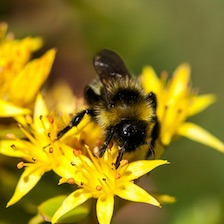

In [17]:
from IPython.display import Image
Image(filename='kitten.jpg')
Image(filename='bee.jpg')

23.893598318099976 seconds
{'predictions': [{'probabilities': [0.428936929, 0.31718412, 0.0627320632], 'classes': [283, 282, 286]}]}


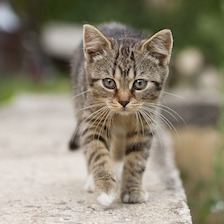

In [27]:
import time
# read the image files into a tensor (numpy array)
kitten_image = sample_utils.image_file_to_tensor('kitten.jpg')

# get a prediction from the endpoint
# the image input is automatically converted to a JSON request.
# the JSON response from the endpoint is returned as a python dict

start = time.time()
for char in "I want to loop as many times as characters I have in this sentence.":
#predictions = [get_prediction(image) for image in images]
 result = predictor.predict(kitten_image)
end = time.time()
print(end - start,'seconds')

# show the raw result
print(result)
from IPython.display import Image
Image(filename='kitten.jpg')

### Add class labels and show formatted results

The `sample_utils` module includes functions that can add Imagenet class labels to our results and print formatted output. Let's use them to get a better sense of how well our model worked on the input image.

In [24]:
# add class labels to the predicted result
sample_utils.add_imagenet_labels(result)

# show the probabilities and labels for the top predictions
sample_utils.print_probabilities_and_labels(result)

0.4289373 n02123159 tiger cat
0.3171842 n02123045 tabby, tabby cat
0.0627320 n02124075 Egyptian cat



## Cleaning up

To avoid incurring charges to your AWS account for the resources used in this tutorial, you need to delete the SageMaker Endpoint.

In [25]:
predictor.delete_endpoint()